# XGBRegressor + RandomizedSearch 를 쓴 submission

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

data_dir = os.getenv('HOME') + '/aiffel/kaggle-kakr-housing-data/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [2]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [3]:
# Date 가 눈에 거슬린다. 전처리 ㄱㄱ
train['date'] = train['date'].apply(lambda i:i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i:i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
# Price 도 처리해주기 (타겟데이터기 때문)

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
del train['id']
del test['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

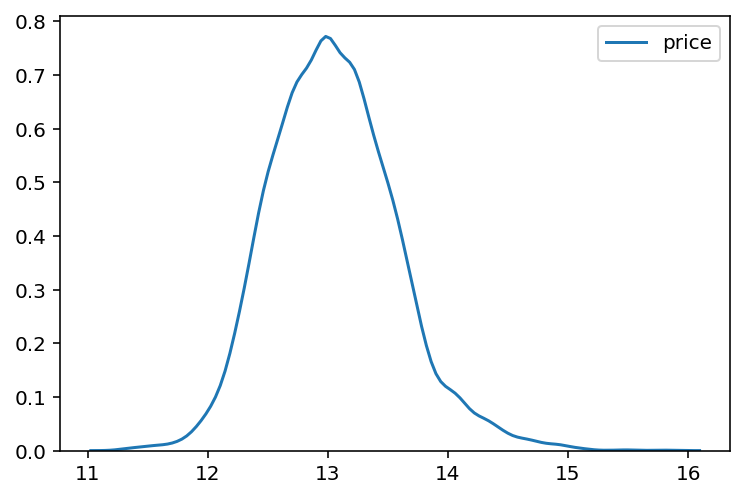

In [7]:
sns.kdeplot(y)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [9]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state = 1000

gboost = GradientBoostingRegressor(random_state = random_state)
xgboost = XGBRegressor(random_state = random_state)
lightgbm = LGBMRegressor(random_state = random_state)
rdforest = RandomForestRegressor(random_state = random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [10]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
    
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state = random_state, test_size = 0.2)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending = False)
        
    return score_df
    
get_scores(models, train, y)

,RMSE
RandomForestRegressor,136338.156764
GradientBoostingRegressor,136006.126298
LGBMRegressor,124587.617192
XGBRegressor,119718.058705


# GridSearch 를 사용했을때

from sklearn.model_selection import GridSearchCV
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,parameters,cv = 2,n_jobs = 5,verbose=True)

xgb_grid.fit(train, y)

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from numpy import random

model = XGBRegressor(random_state= 2000)

num_boost_round = [int(x) for x in np.linspace(start = 10, stop = 200, num=10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

param_grid = {
    'num_boost_round' : num_boost_round,
    'max_depth' : max_depth,
}
    
xgbr_model = RandomizedSearchCV(model, param_grid, n_jobs=5, cv=2)
xgbr_model.fit(train, y)


[15:11:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

In [12]:
xgbr_model.cv_results_

{'mean_fit_time': array([0.91174185, 0.904302  , 0.91219711, 0.87914312, 0.9324919 ,
        0.91433644, 0.68472123, 0.87795937, 0.85471535, 0.88154829]),
 'std_fit_time': array([0.00173271, 0.06265461, 0.03313398, 0.0717026 , 0.02899373,
        0.02658892, 0.05539036, 0.0054332 , 0.05500603, 0.01786697]),
 'mean_score_time': array([0.02994227, 0.02697539, 0.02755368, 0.02771175, 0.02775502,
        0.02878809, 0.02930665, 0.02751958, 0.02493906, 0.02314937]),
 'std_score_time': array([0.00092506, 0.00234914, 0.00056922, 0.00020373, 0.00179958,
        0.00046492, 0.00221539, 0.00020587, 0.00171733, 0.00054085]),
 'param_num_boost_round': masked_array(data=[200, 115, 10, 10, 31, 157, 136, 10, 157, 94],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[30, 100, 80, 40, 90, 50, 10, 30, 110, 60],
              mask=[False, False, False, F

In [13]:
params = xgbr_model.cv_results_['params']
params

[{'num_boost_round': 200, 'max_depth': 30},
 {'num_boost_round': 115, 'max_depth': 100},
 {'num_boost_round': 10, 'max_depth': 80},
 {'num_boost_round': 10, 'max_depth': 40},
 {'num_boost_round': 31, 'max_depth': 90},
 {'num_boost_round': 157, 'max_depth': 50},
 {'num_boost_round': 136, 'max_depth': 10},
 {'num_boost_round': 10, 'max_depth': 30},
 {'num_boost_round': 157, 'max_depth': 110},
 {'num_boost_round': 94, 'max_depth': 60}]

In [14]:
score = xgbr_model.cv_results_['mean_test_score']
score

array([0.87191835, 0.87233212, 0.87233212, 0.87250674, 0.87233212,
       0.87233212, 0.88245677, 0.87191835, 0.87233212, 0.87233212])

In [15]:
results = pd.DataFrame(params)
results['score'] = score
results

,num_boost_round,max_depth,score
0,200,30,0.871918
1,115,100,0.872332
2,10,80,0.872332
3,10,40,0.872507
4,31,90,0.872332
5,157,50,0.872332
6,136,10,0.882457
7,10,30,0.871918
8,157,110,0.872332
9,94,60,0.872332


In [16]:
results['RMSE'] = np.sqrt(results['score'])
results = results.sort_values('RMSE')
results

,num_boost_round,max_depth,score,RMSE
0,200,30,0.871918,0.933766
7,10,30,0.871918,0.933766
1,115,100,0.872332,0.933987
2,10,80,0.872332,0.933987
4,31,90,0.872332,0.933987
5,157,50,0.872332,0.933987
8,157,110,0.872332,0.933987
9,94,60,0.872332,0.933987
3,10,40,0.872507,0.934081
6,136,10,0.882457,0.939392


In [17]:
model = XGBRegressor(num_boost_round = 48, max_depth = 5, random_state = 2000)

model.fit(train,y)
prediction = model.predict(test)
prediction

[15:11:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




array([13.212636, 12.988396, 14.125601, ..., 13.042138, 12.725592,
       13.077615], dtype=float32)

In [18]:
prediction = np.expm1(prediction)
prediction

array([ 547235.3 ,  437308.16, 1363547.2 , ...,  461453.22,  336242.75,
        478117.94], dtype=float32)

In [19]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle-kakr-housing-data/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [20]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.472353e+05
1,15036,4.373082e+05
2,15037,1.363547e+06
3,15038,3.168734e+05
4,15039,3.285668e+05


In [21]:
submission_csv_path = '{}/submission_{}.csv'.format(data_dir, 'Kyuhwan_Jung-last')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel/aiffel/kaggle-kakr-housing-data/data/submission_Kyuhwan_Jung-last.csv


Populating the interactive namespace from numpy and matplotlib


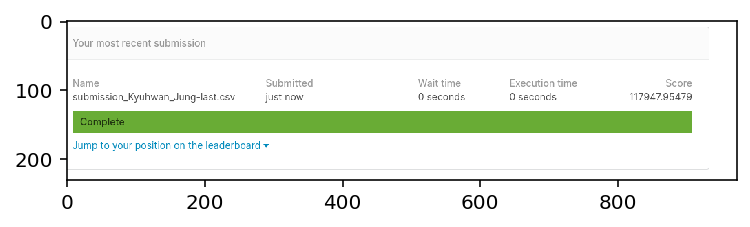

In [27]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('kjkaggle.png')
imgplot = plt.imshow(img)
plt.show()

# 117900 정도 나왔습니다. 1차땐 137000

똑같은 RandomSearch 라도 parameter 범위를 어떻게 설정하느냐에 따라서도 결과가 천차만별이었습니다.

예를들어 n_estimators (XGBRegressor 의 경우엔 num_boost_round) 를 random.randint 로 지정해주는 방법과 for 문을 쓰는 방법이 있었습니다. 물론 for 문으로 할 경우 시간이 다소 오래걸려 지양하였습니다. 2차땐 4개모델중 점수가 가장 높은 XGBRegressor 를 사용하여 좀더 나은 점수를 얻을수 있었습니다. 하지만 이런 오히려 단순한 회귀문제에는 Linear Regression 이 더 좋을거 같기도 합니다. overfitting 되어 결과가 오히려 안좋게 나오는점도 있는것 같습니다. 